In [40]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [41]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [42]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [43]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [44]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [45]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
N_gridcells = np.where((land_sea_mask.lsm[0,:,:].values.reshape([lat.size*lon.size]))>0)[0].size

In [46]:
# for y, year in enumerate(range(1981, 2020+1)):
#     os.rename('%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d.dat'%(dirHeatData, year), '%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d_%d.dat'%(dirHeatData, 95, year))

In [47]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_irr = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear', reuse_weights=True)

irrigationData_regrid = regridder_irr(irrigationData)
irrigationData_regrid_1d = irrigationData_regrid.reshape([irrigationData_regrid.size,1])

Reuse existing file: bilinear_2160x4320_721x1440.nc


In [48]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])

In [49]:
ds_grow_r_t_et1 = xr.open_dataset('r_t_et_era5_not_crop_restricted_1981_2000.nc')
ds_grow_r_t_et1.load()
ds_grow_r_t_et2 = xr.open_dataset('r_t_et_era5_not_crop_restricted_2001_2018.nc')
ds_grow_r_t_et2.load()

ds_grow_r_t_et_diff = ds_grow_r_t_et2-ds_grow_r_t_et1

In [50]:
ds_grow_r_t_et_total_evap_1 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_1981.nc')
ds_grow_r_t_et_total_evap_1.load()

ds_grow_r_t_et_total_evap_2 = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001.nc')
ds_grow_r_t_et_total_evap_2.load()

ds_grow_r_t_et_total_evap_3 = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021.nc')
ds_grow_r_t_et_total_evap_3.load()


ds_grow_r_t_et = xr.open_dataset('r_t_et_era5_total_evaporation_1961_2021.nc')
ds_grow_r_t_et.load()

ds_grow_r_t_et_crop = xr.open_dataset('r_t_et_era5_crop_restricted_1981_2018.nc')
ds_grow_r_t_et_crop.load();

In [51]:
yearRange = np.arange(1981, 2020+1)

In [52]:
tx_during_tw_cmip6 = xr.Dataset()
tw_during_tx_cmip6 = xr.Dataset()

percentiles = np.array([80, 90, 95, 96, 97, 98, 99])

tx_during_tw = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tw_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tx_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)
tw_during_tw = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

et_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
et_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

huss_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
huss_during_tx = np.full([len(yearRange), lat.size, lon.size], np.nan)

sm_during_tw = np.full([len(yearRange), lat.size, lon.size], np.nan)
sm_during_tx = np.full([percentiles.size, len(yearRange), lat.size, lon.size], np.nan)

for y_ind, y in enumerate(yearRange):
    for p in range(percentiles.size):
        with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tw_during_tx[p, y_ind, :, :] = pickle.load(f)
        with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tx_during_tw[p, y_ind, :, :] = pickle.load(f)

        with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tw_during_tw[p, y_ind, :, :] = pickle.load(f)
        with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
            tx_during_tx[p, y_ind, :, :] = pickle.load(f)
            
        if os.path.isfile('%s/heat-wave-days/et-on-tx/era5_et_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y)):
            with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
                et_during_tx[p, y_ind, :, :] = pickle.load(f)
                
        if os.path.isfile('%s/heat-wave-days/sm-on-tx/era5_sm_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y)):
            with open('%s/heat-wave-days/sm-on-tx/era5_sm_on_tx_%d_%d.dat'%(dirHeatData, percentiles[p], y), 'rb') as f:
                sm_during_tx[p, y_ind, :, :] = pickle.load(f)
        
       
    with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_95_%d.dat'%(dirHeatData, y), 'rb') as f:
        et_during_tw[y_ind, :, :] = pickle.load(f)
        
    with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_%d.dat'%(dirHeatData, y), 'rb') as f:
        huss_during_tx[y_ind, :, :] = pickle.load(f)
    with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_%d.dat'%(dirHeatData, y), 'rb') as f:
        huss_during_tw[y_ind, :, :] = pickle.load(f)
        
        


In [53]:
tx_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tx_diff_from_tw_during_tw_trend = np.full([lat.size, lon.size], np.nan)
tx_diff_from_tw_during_tw_pval = np.full([lat.size, lon.size], np.nan)

tw_diff_from_tx_during_tx_trend = np.full([lat.size, lon.size], np.nan)
tw_diff_from_tx_during_tx_pval = np.full([lat.size, lon.size], np.nan)

et_during_tw_trend = np.full([lat.size, lon.size], np.nan)
et_during_tw_pval = np.full([lat.size, lon.size], np.nan)

et_during_tx_trend = np.full([lat.size, lon.size], np.nan)
et_during_tx_pval = np.full([lat.size, lon.size], np.nan)

huss_during_tw_trend = np.full([lat.size, lon.size], np.nan)
huss_during_tw_pval = np.full([lat.size, lon.size], np.nan)

huss_during_tx_trend = np.full([lat.size, lon.size], np.nan)
huss_during_tx_pval = np.full([lat.size, lon.size], np.nan)

with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_during_tx_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_during_tw_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/tx-on-tw/era5_tx_diff_from_tw_during_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tx_diff_from_tw_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/tw-on-tx/era5_tw_diff_from_tx_during_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    tw_diff_from_tx_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tw/era5_et_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/et-on-tx/era5_et_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    et_during_tx_pval = pickle.load(f)
    
    
with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_trend.dat'%(dirHeatData), 'rb') as f:
    huss_during_tw_trend = pickle.load(f)
with open('%s/heat-wave-days/huss-on-tw/era5_huss_on_tw_trend_pval.dat'%(dirHeatData), 'rb') as f:
    huss_during_tw_pval = pickle.load(f)
    
with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_trend.dat'%(dirHeatData), 'rb') as f:
    huss_during_tx_trend = pickle.load(f)
with open('%s/heat-wave-days/huss-on-tx/era5_huss_on_tx_trend_pval.dat'%(dirHeatData), 'rb') as f:
    huss_during_tx_pval = pickle.load(f)
    

In [54]:
# for m, model in enumerate(cmip6_models):
#     print('loading %s'%model)
    
#     tx_during_tw_cur_model = xr.Dataset()
#     tw_during_tx_cur_model = xr.Dataset()
    
#     for y_ind, y in enumerate(yearRange):
#         ds_tw_on_tx = xr.open_dataset('%s/heat-wave-days/tw-on-tx/cmip6/%s/cmip6_tw_on_tx_%d_%s.nc'%(dirHeatData, model, y, model))
#         ds_tx_on_tw = xr.open_dataset('%s/heat-wave-days/tx-on-tw/cmip6/%s/cmip6_tx_on_tw_%d_%s.nc'%(dirHeatData, model, y, model))
    
#         if y_ind == 0:
#             tx_during_tw_cur_model = ds_tx_on_tw
#             tw_during_tx_cur_model = ds_tw_on_tx
#         else:
#             tx_during_tw_cur_model = xr.concat([tx_during_tw_cur_model, ds_tx_on_tw], dim='time')
#             tw_during_tx_cur_model = xr.concat([tw_during_tx_cur_model, ds_tw_on_tx], dim='time')
    
#     if m == 0:
#         tx_during_tw_cmip6 = tx_during_tw_cur_model
#         tw_during_tx_cmip6 = tw_during_tx_cur_model
#     else:
#         tx_during_tw_cmip6 = xr.concat([tx_during_tw_cmip6, tx_during_tw_cur_model], dim='model')
#         tw_during_tx_cmip6 = xr.concat([tw_during_tx_cmip6, tw_during_tx_cur_model], dim='model')

In [55]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.set_extent([-180, -180, 70, -60])

# v1 = 0
# v2 = 1.01
# vstep = .1
# vlabelstep = .25

# midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
# cmap = plt.cm.get_cmap('Reds')

# # data = ds_grow_r_t_et.r_t_et.values
# data = np.nanmean(tx_during_tw, axis=0)
# c = plt.pcolormesh(lon, lat, data, \
#                  cmap=cmap, norm=midnorm)

# ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# # plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
# scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=25, shrink=1)
# cb.ax.tick_params(labelsize=20)
# cb.set_label('Tx during Tw (Percentile)', fontsize=20)

# # plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [56]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.set_extent([-180, -180, 70, -60])

# v1 = -.01
# v2 = .011
# vstep = .001
# vlabelstep = .005

# midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
# cmap = plt.cm.get_cmap('bwr')

# # data = ds_grow_r_t_et.r_t_et.values
# data = tx_during_tx_trend * 10
# c = plt.pcolormesh(lon, lat, data, \
#                  cmap=cmap, norm=midnorm)

# ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# # plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
# scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
# scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=25, shrink=1)
# cb.ax.tick_params(labelsize=20)
# cb.set_label('Trend in Tx during Tx (Percentile/decade)', fontsize=20)

# # plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [57]:
# tx_during_tw_trend_conc = tx_during_tw_trend.copy()
# tw_during_tx_trend_conc = tw_during_tx_trend.copy()
# tx_during_tw_trend_conc[~((tx_during_tw_trend>0) & (tw_during_tx_trend>0))] = np.nan
# tw_during_tx_trend_conc[~((tx_during_tw_trend>0) & (tw_during_tx_trend>0))] = np.nan

# tx_during_tw_trend_div_tx_up = tx_during_tw_trend.copy()
# tw_during_tx_trend_div_tx_up = tw_during_tx_trend.copy()
# tx_during_tw_trend_div_tx_up[~((tx_during_tw_trend>0) & (tw_during_tx_trend<0))] = np.nan
# tw_during_tx_trend_div_tx_up[~((tx_during_tw_trend>0) & (tw_during_tx_trend<0))] = np.nan

# tx_during_tw_trend_div_tx_down = tx_during_tw_trend.copy()
# tw_during_tx_trend_div_tx_down = tw_during_tx_trend.copy()
# tx_during_tw_trend_div_tx_down[~((tx_during_tw_trend<0) & (tw_during_tx_trend>0))] = np.nan
# tw_during_tx_trend_div_tx_down[~((tx_during_tw_trend<0) & (tw_during_tx_trend>0))] = np.nan


# et_during_tw_trend_conc = et_during_tw_trend.copy()
# et_during_tx_trend_conc = et_during_tx_trend.copy()
# et_during_tw_trend_conc[~((tx_during_tw_trend>0) & (tw_during_tx_trend>0))] = np.nan
# et_during_tx_trend_conc[~((tx_during_tw_trend>0) & (tw_during_tx_trend>0))] = np.nan

# tx_during_tw_trend_conc_down = tx_during_tw_trend.copy()
# tw_during_tx_trend_conc_down = tw_during_tx_trend.copy()
# tx_during_tw_trend_conc_down[~((tx_during_tw_trend<0) & (tw_during_tx_trend<0))] = np.nan
# tw_during_tx_trend_conc_down[~((tx_during_tw_trend<0) & (tw_during_tx_trend<0))] = np.nan

# et_during_tw_trend_conc_down = et_during_tw_trend.copy()
# et_during_tx_trend_conc_down = et_during_tx_trend.copy()
# et_during_tw_trend_conc_down[~((tx_during_tw_trend<0) & (tw_during_tx_trend<0))] = np.nan
# et_during_tx_trend_conc_down[~((tx_during_tw_trend<0) & (tw_during_tx_trend<0))] = np.nan

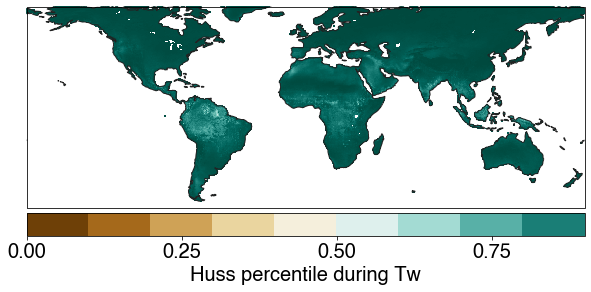

In [58]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(huss_during_tw, axis=0)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Huss percentile during Tw', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

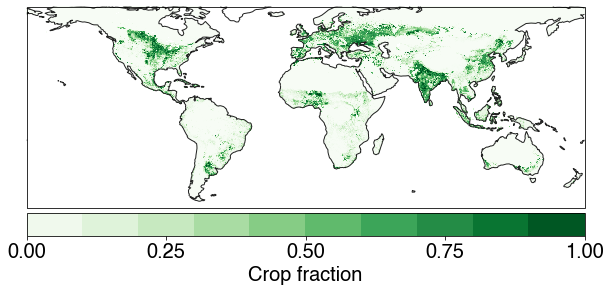

In [59]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

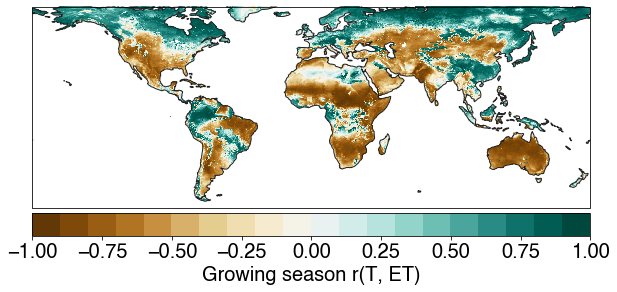

In [60]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET)', fontsize=20)

plt.savefig('growing-season-r-t-et-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

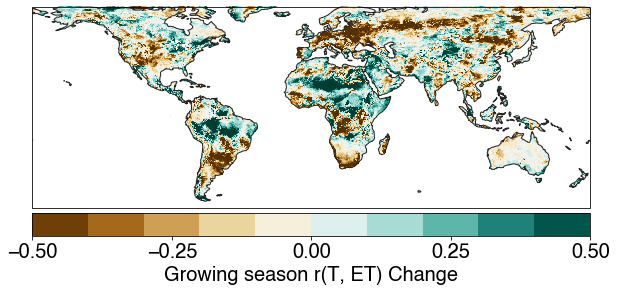

In [61]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.5
v2 = .51
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et_total_evap_3.r_t_et.values-ds_grow_r_t_et_total_evap_1.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET) Change', fontsize=20)

plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [62]:
lat_global_ind = np.arange(lat.size)
lat_global_no_ice_ind = np.where((lat>=-65) & (lat<=60))[0]
lat_nontropics_ind = np.where(((lat>=30) | (lat<=-30)) & (lat<=65) & (lat>=-65))[0]
lat_nh_ind = np.where((lat>=30) & (lat<=65))[0]
lat_tropics_ind = np.where((lat<30) & (lat>-30))[0]
lat_sh_ind = np.where((lat <= -30) & (lat >= -60))[0]


In [63]:
lat_ind_sel = lat_nontropics_ind

time_split = 20

# determine array size
num_elements = np.nanmean(tx_during_tw[0,:,:,:], axis=0)
num_elements = num_elements[lat_ind_sel,:].size

tx_during_tw_sel_1d = np.full([percentiles.size, num_elements], np.nan)

tx_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tx_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tx_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

tw_during_tw_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
tw_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

et_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
et_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
et_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

sm_during_tx_sel_1d = np.full([percentiles.size, num_elements], np.nan)
sm_during_tx_sel_1_1d = np.full([percentiles.size, num_elements], np.nan)
sm_during_tx_sel_2_1d = np.full([percentiles.size, num_elements], np.nan)

for p in range(percentiles.size):
    
    t = np.nanmean(tx_during_tw[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tx_during_tw_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tx_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    tx_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tx_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    tx_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(et_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    et_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(et_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    et_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(et_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    et_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(sm_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    sm_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(sm_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel, :]
    sm_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(sm_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel, :]
    sm_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    
    
    t = np.nanmean(tw_during_tx[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tx[p, 0:time_split, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_1_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tx[p, time_split:, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tx_sel_2_1d[p, :] = t.reshape([t.size])
    
    t = np.nanmean(tw_during_tw[p, :, :, :], axis=0)
    t = t[lat_ind_sel,:]
    tw_during_tw_sel_1d[p, :] = t.reshape([t.size])

In [64]:

et_during_tw_sel = np.nanmean(et_during_tw, axis=0)
et_during_tw_sel = et_during_tw_sel[lat_ind_sel,:]
et_during_tw_sel_1d = et_during_tw_sel.reshape([et_during_tw_sel.size, 1])

# et_during_tx_sel = np.nanmean(et_during_tx, axis=0)
# et_during_tx_sel = et_during_tx_sel[lat_ind_sel,:]
# et_during_tx_sel_1d = et_during_tx_sel.reshape([et_during_tx_sel.size, 1])

# et_during_tx_1_sel = np.nanmean(et_during_tx[0:20,:,:], axis=0)
# et_during_tx_1_sel = et_during_tx_1_sel[lat_ind_sel,:]
# et_during_tx_1_sel_1d = et_during_tx_1_sel.reshape([et_during_tx_1_sel.size, 1])

# et_during_tx_2_sel = np.nanmean(et_during_tx[20:,:,:], axis=0)
# et_during_tx_2_sel = et_during_tx_2_sel[lat_ind_sel,:]
# et_during_tx_2_sel_1d = et_during_tx_2_sel.reshape([et_during_tx_2_sel.size, 1])

# huss_during_tx_sel = np.nanmean(huss_during_tx, axis=0)
# huss_during_tx_sel = huss_during_tx_sel[lat_ind_sel,:]
# huss_during_tx_sel_1d = huss_during_tx_sel.reshape([huss_during_tx_sel.size, 1])

huss_during_tx_1_sel = np.nanmean(huss_during_tx[0:time_split,:,:], axis=0)
huss_during_tx_1_sel = huss_during_tx_1_sel[lat_ind_sel,:]
huss_during_tx_1_sel_1d = huss_during_tx_1_sel.reshape([huss_during_tx_1_sel.size, 1])

huss_during_tx_2_sel = np.nanmean(huss_during_tx[time_split:,:,:], axis=0)
huss_during_tx_2_sel = huss_during_tx_2_sel[lat_ind_sel,:]
huss_during_tx_2_sel_1d = huss_during_tx_2_sel.reshape([huss_during_tx_2_sel.size, 1])

# sm_during_tx_1_sel = np.nanmean(sm_during_tx[0:20,:,:], axis=0)
# sm_during_tx_1_sel = sm_during_tx_1_sel[lat_ind_sel,:]
# sm_during_tx_1_sel_1d = sm_during_tx_1_sel.reshape([sm_during_tx_1_sel.size, 1])

# sm_during_tx_2_sel = np.nanmean(sm_during_tx[20:,:,:], axis=0)
# sm_during_tx_2_sel = sm_during_tx_2_sel[lat_ind_sel,:]
# sm_during_tx_2_sel_1d = sm_during_tx_2_sel.reshape([sm_during_tx_2_sel.size, 1])

huss_during_tw_sel = np.nanmean(huss_during_tw, axis=0)
huss_during_tw_sel = huss_during_tw_sel[lat_ind_sel,:]
huss_during_tw_sel_1d = huss_during_tw_sel.reshape([huss_during_tw_sel.size, 1])

et_during_tw_trend_sel = et_during_tw_trend[lat_ind_sel, :]*10
et_during_tw_trend_zonal_sel = (et_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(et_during_tw_trend[lat_ind_sel, :],  axis=1), et_during_tw_trend.shape[1], 1).T)*10
et_during_tw_trend_sel_1d = np.reshape(et_during_tw_trend_sel, [et_during_tw_trend_sel.size, 1])
et_during_tw_trend_zonal_sel_1d = np.reshape(et_during_tw_trend_zonal_sel, [et_during_tw_trend_zonal_sel.size, 1])

huss_during_tw_trend_sel = huss_during_tw_trend[lat_ind_sel, :]*10
huss_during_tw_trend_zonal_sel = (huss_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(huss_during_tw_trend[lat_ind_sel, :],  axis=1), huss_during_tw_trend.shape[1], 1).T)*10
huss_during_tw_trend_sel_1d = np.reshape(huss_during_tw_trend_sel, [huss_during_tw_trend_sel.size, 1])
huss_during_tw_trend_zonal_sel_1d = np.reshape(huss_during_tw_trend_zonal_sel, [huss_during_tw_trend_zonal_sel.size, 1])

tw_during_tw_trend_sel = tw_during_tw_trend[lat_ind_sel, :]*10
tw_during_tw_trend_zonal_sel = (tw_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tw_during_tw_trend[lat_ind_sel, :],  axis=1), tw_during_tw_trend.shape[1], 1).T)*10
tw_during_tw_trend_sel_1d = np.reshape(tw_during_tw_trend_sel, [tw_during_tw_trend_sel.size, 1])
tw_during_tw_trend_zonal_sel_1d = np.reshape(tw_during_tw_trend_zonal_sel, [tw_during_tw_trend_zonal_sel.size, 1])

tx_during_tw_trend_sel = tx_during_tw_trend[lat_ind_sel, :]*10
tx_during_tw_trend_zonal_sel = (tx_during_tw_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tx_during_tw_trend[lat_ind_sel, :],  axis=1), tx_during_tw_trend.shape[1], 1).T)*10
tx_during_tw_trend_sel_1d = np.reshape(tx_during_tw_trend_sel, [tx_during_tw_trend_sel.size, 1])
tx_during_tw_trend_zonal_sel_1d = np.reshape(tx_during_tw_trend_zonal_sel, [tx_during_tw_trend_zonal_sel.size, 1])

et_during_tx_trend_sel = et_during_tx_trend[lat_ind_sel, :]*10
et_during_tx_trend_zonal_sel = (et_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(et_during_tx_trend[lat_ind_sel, :],  axis=1), et_during_tx_trend.shape[1], 1).T)*10
et_during_tx_trend_sel_1d = np.reshape(et_during_tx_trend_sel, [et_during_tx_trend_sel.size, 1])
et_during_tx_trend_zonal_sel_1d = np.reshape(et_during_tx_trend_zonal_sel, [et_during_tx_trend_zonal_sel.size, 1])

huss_during_tx_trend_sel = huss_during_tx_trend[lat_ind_sel, :]*10
huss_during_tx_trend_zonal_sel = (huss_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(huss_during_tx_trend[lat_ind_sel, :],  axis=1), huss_during_tx_trend.shape[1], 1).T)*10
huss_during_tx_trend_sel_1d = np.reshape(huss_during_tx_trend_sel, [huss_during_tx_trend_sel.size, 1])
huss_during_tx_trend_zonal_sel_1d = np.reshape(huss_during_tx_trend_zonal_sel, [huss_during_tx_trend_zonal_sel.size, 1])

tw_during_tx_trend_sel = tw_during_tx_trend[lat_ind_sel, :]*10
tw_during_tx_trend_zonal_sel = (tw_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tw_during_tx_trend[lat_ind_sel, :],  axis=1), tw_during_tx_trend.shape[1], 1).T)*10
tw_during_tx_trend_sel_1d = np.reshape(tw_during_tx_trend_sel, [tw_during_tx_trend_sel.size, 1])
tw_during_tx_trend_zonal_sel_1d = np.reshape(tw_during_tx_trend_zonal_sel, [tw_during_tx_trend_zonal_sel.size, 1])

tx_during_tx_trend_sel = tx_during_tx_trend[lat_ind_sel, :]*10
tx_during_tx_trend_zonal_sel = (tx_during_tx_trend[lat_ind_sel, :]-np.matlib.repmat(np.nanmean(tx_during_tx_trend[lat_ind_sel, :],  axis=1), tx_during_tx_trend.shape[1], 1).T)*10
tx_during_tx_trend_sel_1d = np.reshape(tx_during_tx_trend_sel, [tx_during_tx_trend_sel.size, 1])
tx_during_tx_trend_zonal_sel_1d = np.reshape(tx_during_tx_trend_zonal_sel, [tx_during_tx_trend_zonal_sel.size, 1])


t_et = ds_grow_r_t_et.r_t_et.values
t_et = t_et[lat_ind_sel,:]
t_et_1d = t_et.reshape([t_et.size, 1])

t_et_diff = ds_grow_r_t_et_diff.r_t_et.values
t_et_diff = t_et_diff[lat_ind_sel,:]
t_et_diff_1d = t_et_diff.reshape([t_et_diff.size, 1])

t_et_1 = ds_grow_r_t_et_total_evap_1.r_t_et.values
t_et_1 = t_et_1[lat_ind_sel,:]
t_et_1_1d = t_et_1.reshape([t_et_1.size, 1])

t_et_2 = ds_grow_r_t_et_total_evap_2.r_t_et.values
t_et_2 = t_et_2[lat_ind_sel,:]
t_et_2_1d = t_et_2.reshape([t_et_2.size, 1])

t_et_3 = ds_grow_r_t_et_total_evap_3.r_t_et.values
t_et_3 = t_et_3[lat_ind_sel,:]
t_et_3_1d = t_et_3.reshape([t_et_3.size, 1])

t_et_crop = ds_grow_r_t_et_crop.r_t_et.values
t_et_crop = t_et_crop[lat_ind_sel,:]
t_et_crop_1d = t_et_crop.reshape([t_et_crop.size, 1])

crop_ha_regrid_sel = crop_ha_regrid[lat_ind_sel,:]
crop_ha_regrid_sel_1d = crop_ha_regrid_sel.reshape([crop_ha_regrid_sel.size, 1])

ind = np.where((np.isnan(crop_ha_regrid_sel_1d)) & (~np.isnan(t_et_1d)))[0]
crop_ha_regrid_sel_1d[ind] = 0

irrigationData_regrid_sel = irrigationData_regrid[lat_ind_sel, :]
irrigationData_regrid_sel_1d = irrigationData_regrid_sel.reshape([irrigationData_regrid_sel.size, 1])


In [67]:
# nn = np.where((~np.isnan(tx_during_tw_trend_sel_1d)) & (irrigationData_regrid_sel_1d/100 > 0.2*crop_ha_regrid_sel_1d))[0]
# nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
#               (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
#               (irrigationData_regrid_sel_1d/100 <= 0.01*crop_ha_regrid_sel_1d))[0]


nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
              (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d>0))[0]

data = {
        'tx_during_tw_trend':tx_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tw_trend':et_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tw_trend':huss_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tw_trend':tw_during_tw_trend_sel_1d[nn].reshape([nn.size]), \
        'tx_during_tx_trend':tx_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'et_during_tx_trend':et_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_trend':huss_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tx_trend':tw_during_tx_trend_sel_1d[nn].reshape([nn.size]), \
        
        'tx_during_tx_trend_zonal':tx_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'et_during_tx_trend_zonal':et_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_trend_zonal':huss_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tx_trend_zonal':tw_during_tx_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        
        'tx_during_tw_trend_zonal':tx_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'et_during_tw_trend_zonal':et_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tw_trend_zonal':huss_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
        'tw_during_tw_trend_zonal':tw_during_tw_trend_zonal_sel_1d[nn].reshape([nn.size]), \
                
        
        'tx_during_tx_99_1':tx_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_99_2':tx_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_98_1':tx_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_98_2':tx_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_97_1':tx_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_97_2':tx_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_96_1':tx_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_96_2':tx_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_95_1':tx_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_95_2':tx_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_90_1':tx_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_90_2':tx_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'tx_during_tx_80_1':tx_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tx_during_tx_80_2':tx_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
    
    
    
        'et_during_tx_99_1':et_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_99_2':et_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
    
    
        'et_during_tx_98_1':et_during_tx_sel_1_1d[np.where(percentiles==98)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_98_2':et_during_tx_sel_2_1d[np.where(percentiles==98)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_97_1':et_during_tx_sel_1_1d[np.where(percentiles==97)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_97_2':et_during_tx_sel_2_1d[np.where(percentiles==97)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_96_1':et_during_tx_sel_1_1d[np.where(percentiles==96)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_96_2':et_during_tx_sel_2_1d[np.where(percentiles==96)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_95_1':et_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_95_2':et_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_90_1':et_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_90_2':et_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'et_during_tx_80_1':et_during_tx_sel_1_1d[np.where(percentiles==80)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
        'et_during_tx_80_2':et_during_tx_sel_2_1d[np.where(percentiles==80)[0],:].reshape([et_during_tx_sel_1_1d[0,:].size])[nn], \
    
        'sm_during_tx_99_1':sm_during_tx_sel_1_1d[np.where(percentiles==99)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_99_2':sm_during_tx_sel_2_1d[np.where(percentiles==99)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        'sm_during_tx_95_1':sm_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_95_2':sm_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
        'sm_during_tx_90_1':sm_during_tx_sel_1_1d[np.where(percentiles==90)[0],:].reshape([sm_during_tx_sel_1_1d[0,:].size])[nn], \
        'sm_during_tx_90_2':sm_during_tx_sel_2_1d[np.where(percentiles==90)[0],:].reshape([sm_during_tx_sel_2_1d[0,:].size])[nn], \
    
                
        'tx_during_tw_95':tx_during_tw_sel_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        
        'tw_during_tx':tw_during_tx_sel_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_1':tw_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_2':tw_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        
        'tw_during_tx_1':tw_during_tx_sel_1_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        'tw_during_tx_2':tw_during_tx_sel_2_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        
        'tw_during_tw':tw_during_tw_sel_1d[np.where(percentiles==95)[0],:].reshape([tx_during_tx_sel_1_1d[0,:].size])[nn], \
        
        'et_during_tw':et_during_tw_sel_1d[nn].reshape([nn.size]), \
        
        'huss_during_tx_1':huss_during_tx_1_sel_1d[nn].reshape([nn.size]), \
        'huss_during_tx_2':huss_during_tx_2_sel_1d[nn].reshape([nn.size]), \
        
        
        'huss_during_tw':huss_during_tw_sel_1d[nn].reshape([nn.size]), \
        'r_t_et':t_et_1d[nn].reshape([nn.size]), \
        'r_t_et_1':t_et_1_1d[nn].reshape([nn.size]), \
        'r_t_et_2':t_et_2_1d[nn].reshape([nn.size]), \
        'r_t_et_3':t_et_3_1d[nn].reshape([nn.size]), \
        'r_t_et_diff':t_et_3_1d[nn].reshape([nn.size])-t_et_2_1d[nn].reshape([nn.size]), \
        'cf':crop_ha_regrid_sel_1d[nn].reshape([nn.size])}


df = pd.DataFrame(data, \
                  columns=[
                            'tx_during_tw_trend', 'huss_during_tw_trend', 'et_during_tw_trend', 'tw_during_tw_trend', \
                           'tx_during_tx_trend', 'huss_during_tx_trend', 'et_during_tx_trend', 'tw_during_tx_trend', \
                           'tx_during_tx_trend_zonal', 'huss_during_tx_trend_zonal', 'et_during_tx_trend_zonal', 'tw_during_tx_trend_zonal', \
                           'tx_during_tw_trend_zonal', 'huss_during_tw_trend_zonal', 'et_during_tw_trend_zonal', 'tw_during_tw_trend_zonal', \
                           'et_during_tx', 'et_during_tw', 'huss_during_tx', 'huss_during_tw', \
                           'tx_during_tx', 'tx_during_tw', 'tw_during_tx', 'tw_during_tw', \
                           'tx_during_tx_1', 'tx_during_tx_2', 'tx_during_tx_diff', \
                           'tx_during_tx_99_1', 'tx_during_tx_99_2', \
                           'tx_during_tx_98_1', 'tx_during_tx_98_2', \
                           'tx_during_tx_97_1', 'tx_during_tx_97_2', \
                           'tx_during_tx_96_1', 'tx_during_tx_96_2', \
                           'tx_during_tx_95_1', 'tx_during_tx_95_2', \
                           'tx_during_tx_90_1', 'tx_during_tx_90_2', \
                           'tx_during_tx_80_1', 'tx_during_tx_80_2', \
                           'et_during_tx_99_1', 'et_during_tx_99_2', \
                            'et_during_tx_98_1', 'et_during_tx_98_2', \
                            'et_during_tx_97_1', 'et_during_tx_97_2', \
                            'et_during_tx_96_1', 'et_during_tx_96_2', \
                            'et_during_tx_95_1', 'et_during_tx_95_2', \
                            'et_during_tx_90_1', 'et_during_tx_90_2', \
                            'et_during_tx_80_1', 'et_during_tx_80_2', \
                           'huss_during_tx_1', 'huss_during_tx_2', \
                           'sm_during_tx_99_1', 'sm_during_tx_99_2', \
                            'sm_during_tx_95_1', 'sm_during_tx_95_2', \
                            'sm_during_tx_90_1', 'sm_during_tx_90_2', \
                           'tw_during_tx_1', 'tw_during_tx_2', \
                           'r_t_et', 'r_t_et_1', 'r_t_et_2', 'r_t_et_3', 'r_t_et_diff', 'cf'])


In [27]:
# cf_bin_step = .1
# cf_bins = np.arange(0, .81, cf_bin_step)

# coefs_cf = []
# coefs_rt = []
# coefs_rt_diff = []

# pvals_cf = []
# pvals_rt = []
# pvals_rt_diff = []

# mdl_r2 = []

# for c, cur_bin in enumerate(cf_bins):

#     if c == 0:
#         ind_cf_all = np.where((data['cf'] < .01))[0]
#     elif c == cf_bins.size-1:
#         ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step))[0]
#     else:
#         ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin))[0]

#     mdl_cur = smf.ols(formula='tx_during_tx_diff ~ cf + r_t_et + r_t_et_diff', data=df, subset = ind_cf_all).fit()
    
#     mdl_r2.append(mdl_cur.rsquared)
    
#     coefs_cf.append(mdl_cur.params['cf'])
#     coefs_rt.append(mdl_cur.params['r_t_et'])
#     coefs_rt_diff.append(mdl_cur.params['r_t_et_diff'])
    
#     pvals_cf.append(mdl_cur.pvalues['cf'])
#     pvals_rt.append(mdl_cur.pvalues['r_t_et'])
#     pvals_rt_diff.append(mdl_cur.pvalues['r_t_et_diff'])

In [28]:
# cf_bin_step = .1
# cf_bins = np.arange(0, .81, cf_bin_step)

# r_t_et_bins = np.arange(-.5, .51, .1)
# r_t_et_diff_bins = np.arange(-.5, .51, .1)

# chg_from_r_t_et_diff = {}
# chg_from_r_t_et = {}
# chg_from_cf = {}

# for c, cur_cf_bin in enumerate(cf_bins):
#     if c == 0:
#         ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] < .01)))[0]
#     elif c == cf_bins.size-1:
#         ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step)))[0]
#     else:
#         ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step) & (data['cf'] < cur_cf_bin)))[0]
    
    
#     chg_from_r_t_et_diff[c] = data['r_t_et_diff'][ind_cf]*coefs_rt_diff[c]
#     chg_from_r_t_et[c] = data['r_t_et'][ind_cf]*coefs_rt[c]
#     chg_from_cf[c] = data['cf'][ind_cf]*coefs_cf[c]

In [29]:
# fig, ax = plt.subplots(1,3, figsize=(14,4))

# t = 'Tx during Tx'

# ax[0].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[1].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[2].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')

# for i, val in enumerate(coefs_cf):
#     if pvals_cf[i] < .05:
#         ax[0].plot([i, i], [np.nanmean(chg_from_cf[i])-np.nanstd(chg_from_cf[i])/2, np.nanmean(chg_from_cf[i])+np.nanstd(chg_from_cf[i])/2], '--', c='#aaaaaa', lw=2)
#         ax[0].plot(i, np.nanmean(chg_from_cf[i]), 'og', markersize=10)
        
#     else:
#         ax[0].plot(i, np.nanmean(chg_from_cf[i]), 'or', markersize=10)
        
        
#     if pvals_rt[i] < .05:
#         ax[1].plot([i, i], [np.nanmean(chg_from_r_t_et[i])-np.nanstd(chg_from_r_t_et[i])/2, np.nanmean(chg_from_r_t_et[i])+np.nanstd(chg_from_r_t_et[i])/2], '--', c='#aaaaaa', lw=2)
#         ax[1].plot(i, np.nanmean(chg_from_r_t_et[i]), 'og', markersize=10)
        
#     else:
#         ax[1].plot(i, np.nanmean(chg_from_r_t_et[i]), 'or', markersize=10)
        
#     if pvals_rt_diff[i] < .05:
#         ax[2].plot([i, i], [np.nanmean(chg_from_r_t_et_diff[i])-np.nanstd(chg_from_r_t_et_diff[i])/2, np.nanmean(chg_from_r_t_et_diff[i])+np.nanstd(chg_from_r_t_et_diff[i])/2], '--', c='#aaaaaa', lw=2)
#         ax[2].plot(i, np.nanmean(chg_from_r_t_et_diff[i]), 'og', markersize=10)
        
#     else:
#         ax[2].plot(i, np.nanmean(chg_from_r_t_et_diff[i]), 'or', markersize=10)
                

# ax[0].set_ylabel('%s change\nfrom mean crop fraction'%t)
# ax[0].set_xlabel('Crop fraction')
# ax[0].set_xticks(range(cf_bins.size))
# ax[0].set_xticklabels(np.round(cf_bins, 1))


# ax[1].set_ylabel('%s change\nfrom mean r(T, ET)'%t)
# ax[1].set_xlabel('Crop fraction')
# ax[1].set_xticks(range(cf_bins.size))
# ax[1].set_xticklabels(np.round(cf_bins, 1))



# ax[2].set_ylabel('%s change\nfrom change in r(T, ET)'%t)
# ax[2].set_xlabel('Crop fraction')
# ax[2].set_xticks(range(cf_bins.size))
# ax[2].set_xticklabels(np.round(cf_bins, 1))

# plt.tight_layout()

# # plt.savefig('tw-during-tx-trend-drivers.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [30]:
# fig, ax = plt.subplots(1,3, figsize=(13,4))

# t = 'Tw during Tx'

# for i, val in enumerate(coefs_cf):
#     if pvals_cf[i] < .05:
#         ax[0].plot(i, val, 'og', markersize=10)
#     else:
#         ax[0].plot(i, val, 'or', markersize=10)
# ax[0].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[0].set_ylabel('%s change\nper mean crop fraction'%t)
# ax[0].set_xlabel('Crop fraction')
# ax[0].set_xticks(range(cf_bins.size))
# ax[0].set_xticklabels(np.round(cf_bins, 1))

# for i, val in enumerate(coefs_rt):
#     if pvals_rt[i] < .05:
#         ax[1].plot(i, val, 'og', markersize=10)
#     else:
#         ax[1].plot(i, val, 'or', markersize=10)
# ax[1].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[1].set_ylabel('%s change\nper mean r(T, ET)'%t)
# ax[1].set_xlabel('Crop fraction')
# ax[1].set_xticks(range(cf_bins.size))
# ax[1].set_xticklabels(np.round(cf_bins, 1))


# for i, val in enumerate(coefs_rt_diff):
#     if pvals_rt_diff[i] < .05:
#         ax[2].plot(i, val, 'og', markersize=10)
#     else:
#         ax[2].plot(i, val, 'or', markersize=10)
# ax[2].plot([0, 8], [0,0], '--', lw=3, c='#aaaaaa')
# ax[2].set_ylabel('%s change\nper change in r(T, ET)'%t)
# ax[2].set_xlabel('Crop fraction')
# ax[2].set_xticks(range(cf_bins.size))
# ax[2].set_xticklabels(np.round(cf_bins, 1))

# plt.tight_layout()

# # plt.savefig('tw-during-tx-trend-coefs.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [68]:
cf_bin_step = .1
cf_bins = np.arange(0, 1.01, cf_bin_step)

gridcell_ct = []

r_t_et_by_cf_bin = {}
r_t_et_1_by_cf_bin = {}
r_t_et_2_by_cf_bin = {}
r_t_et_3_by_cf_bin = {}

tx_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
tx_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

tx_during_tx_trend_by_cf_bin = np.full([cf_bins.size], np.nan)

et_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
et_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)

sm_during_tx_by_cf_bin_1 = np.full([percentiles.size, cf_bins.size], np.nan)
sm_during_tx_by_cf_bin_2 = np.full([percentiles.size, cf_bins.size], np.nan)


huss_during_tx_by_cf_bin = []
huss_during_tx_by_cf_bin_1 = []
huss_during_tx_by_cf_bin_2 = []

tw_during_tx_by_cf_bin = []
tw_during_tx_by_cf_bin_1 = []
tw_during_tx_by_cf_bin_2 = []


for c, cur_bin in enumerate(cf_bins):
    
    if c == 0:
        nn = np.where((data['cf'] < .01))[0]
    elif c == cf_bins.size-1:
        nn = np.where((data['cf'] > cur_bin-cf_bin_step))[0]
    else:
        nn = np.where(((data['cf'] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin)))[0]
    
    gridcell_ct.append(nn.size)
    
    r_t_et_by_cf_bin[c] = data['r_t_et'][nn]
    r_t_et_1_by_cf_bin[c] = data['r_t_et_1'][nn]
    r_t_et_2_by_cf_bin[c] = data['r_t_et_2'][nn]
    r_t_et_3_by_cf_bin[c] = data['r_t_et_3'][nn]
    
    for p in range(percentiles.size):
        tx_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['tx_during_tx_%d_1'%percentiles[p]][nn])
        tx_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['tx_during_tx_%d_2'%percentiles[p]][nn])
        
        if 'et_during_tx_%d_1'%percentiles[p] in data.keys():
            et_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['et_during_tx_%d_1'%percentiles[p]][nn])
            et_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['et_during_tx_%d_2'%percentiles[p]][nn])
            
        if 'sm_during_tx_%d_1'%percentiles[p] in data.keys():
            sm_during_tx_by_cf_bin_1[p, c] = np.nanmean(data['sm_during_tx_%d_1'%percentiles[p]][nn])
            sm_during_tx_by_cf_bin_2[p, c] = np.nanmean(data['sm_during_tx_%d_2'%percentiles[p]][nn])

   
    tx_during_tx_trend_by_cf_bin[c] = np.nanmean(data['tx_during_tx_trend'][nn])

    huss_during_tx_by_cf_bin_1.append(np.nanmean(data['huss_during_tx_1'][nn]))
    huss_during_tx_by_cf_bin_2.append(np.nanmean(data['huss_during_tx_2'][nn]))
    
    tw_during_tx_by_cf_bin_1.append(np.nanmean(data['tw_during_tx_1'][nn]))
    tw_during_tx_by_cf_bin_2.append(np.nanmean(data['tw_during_tx_2'][nn]))
    
    
    if c == 0:
        nn = np.where(((~np.isnan(data['et_during_tw_trend'])) | (~np.isnan(data['tx_during_tw_trend']))) & (data['cf'] < .01))[0]
    elif c == cf_bins.size-1:
        nn = np.where(((~np.isnan(data['et_during_tw_trend'])) | (~np.isnan(data['tx_during_tw_trend']))) & (data['cf'] > cur_bin-cf_bin_step))[0]
    else:
        nn = np.where(((~np.isnan(data['et_during_tw_trend'])) | (~np.isnan(data['tx_during_tw_trend']))) & (data['cf'] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin))[0]
    
#     huss_during_tw_binned.append(np.nanmean(data['huss_during_tw'][nn]))
#     et_during_tw_binned.append(np.nanmean(data['et_during_tw'][nn]))
#     tx_during_tw_binned.append(np.nanmean(data['tx_during_tw'][nn]))
#     tw_during_tw_binned.append(np.nanmean(data['tw_during_tw'][nn]))
    
#     huss_during_tw_trend_binned.append(np.nanmean(data['huss_during_tw_trend'][nn]))
#     et_during_tw_trend_binned.append(np.nanmean(data['et_during_tw_trend'][nn]))
#     tx_during_tw_trend_binned.append(np.nanmean(data['tx_during_tw_trend'][nn]))
#     tw_during_tw_trend_binned.append(np.nanmean(data['tw_during_tw_trend'][nn]))
    



In [32]:
gridcell_ct

[10974, 25909, 6832, 5023, 4056, 3467, 3663, 3768, 2919, 1536, 745]

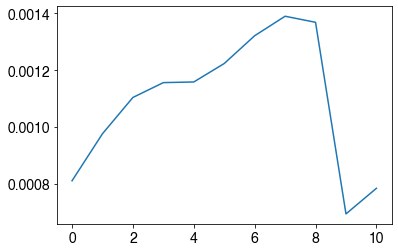

In [33]:
plt.plot(tx_during_tx_trend_by_cf_bin)

Text(0, 0.5, 'Change in Tx percentile\n(2000-2020 minus 1981-2000)')

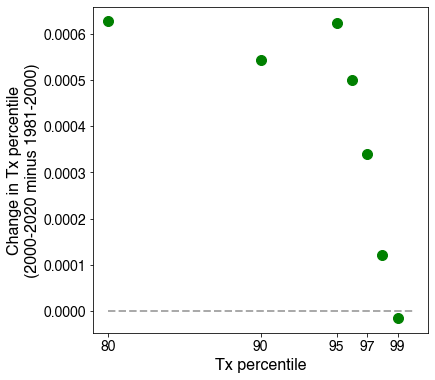

In [83]:
pct = np.array([80,90,95,96,97,98,99])

cf_tx_slope = []
cf_tx_pval = []

for p in pct:

    X = sm.add_constant(data['cf'])
    mdl_cur = sm.OLS(data['tx_during_tx_%d_2'%p]-data['tx_during_tx_%d_1'%p], X).fit()
    cf_tx_slope.append(mdl_cur.params[1])
    cf_tx_pval.append(mdl_cur.pvalues[1])
    

plt.figure(figsize=(6,6))
plt.plot([80, 100], [0, 0], '--', c='#aaaaaa', lw=2)
for p in range(pct.size):
    if cf_tx_pval[p] < .05:
        plt.plot(pct[p], cf_tx_slope[p], 'og',  markersize=10)
    else:
        plt.plot(pct[p], cf_tx_slope[p], 'or',  markersize=10)
plt.xticks([80, 90, 95, 97, 99])
plt.xlabel('Tx percentile')
plt.ylabel('Change in Tx percentile\n(2000-2020 minus 1981-2000)')

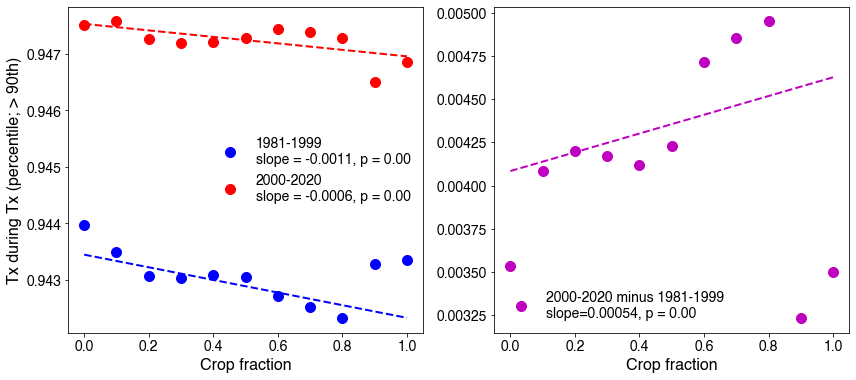

In [35]:
pct = 90
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['tx_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['tx_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['tx_during_tx_%d_2'%pct]-data['tx_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Tx during Tx (percentile; > %dth)'%pct)
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 14}, frameon=False)

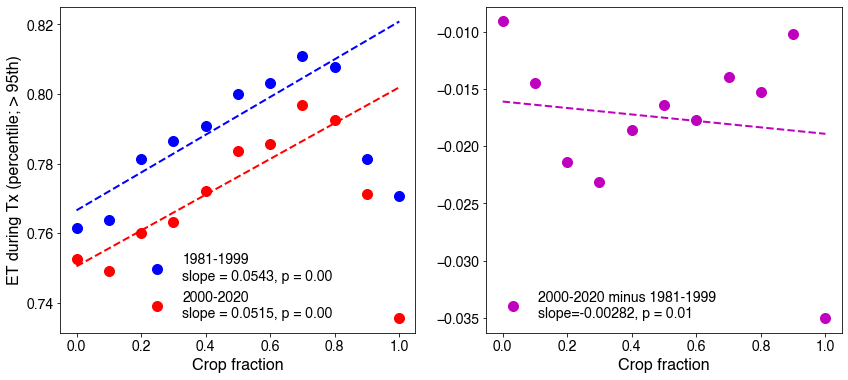

In [75]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['et_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['et_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['et_during_tx_%d_2'%pct]-data['et_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('ET during Tx (percentile; > 95th)')
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 14}, frameon=False)

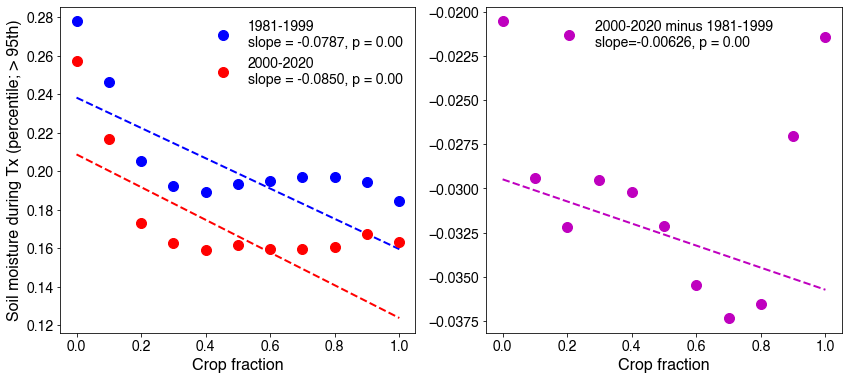

In [79]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['sm_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['sm_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['sm_during_tx_%d_2'%pct]-data['sm_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Soil moisture during Tx (percentile; > %dth)'%pct)
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 14}, frameon=False)

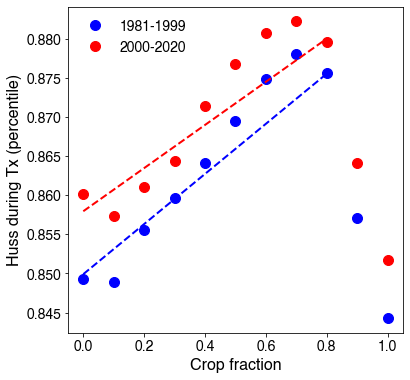

In [38]:
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['huss_during_tx_1'], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['huss_during_tx_2'], X).fit()


plt.figure(figsize=(6,6))

plt.plot(cf_bins, huss_during_tx_by_cf_bin_1, 'ob', markersize=10, label='1981-1999')
plt.plot([0, .8], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+0.8*mdl_1.params[1]], '--b', lw=2)

plt.plot(cf_bins, huss_during_tx_by_cf_bin_2, 'or', markersize=10, label='2000-2020')
plt.plot([0, .8], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+0.8*mdl_2.params[1]], '--r', lw=2)

# plt.plot(cf_bins, et_during_tx_by_cf_bin, 'om', markersize=10, label='1981-2020')
    
# plt.gca().set_xticks(range(0,cf_bins.size,2))
# plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('Huss during Tx (percentile)')
plt.legend(prop={'size': 14}, frameon=False)

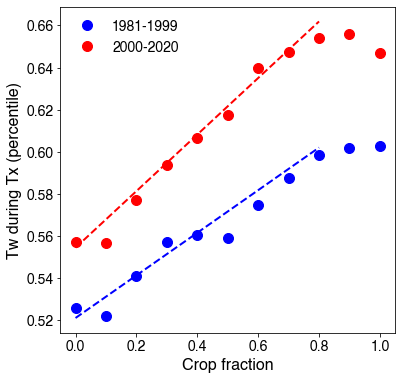

In [305]:
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['tw_during_tx_1'], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['tw_during_tx_2'], X).fit()


plt.figure(figsize=(6,6))

plt.plot(cf_bins, tw_during_tx_by_cf_bin_1, 'ob', markersize=10, label='1981-1999')
plt.plot([0, .8], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+0.8*mdl_1.params[1]], '--b', lw=2)

plt.plot(cf_bins, tw_during_tx_by_cf_bin_2, 'or', markersize=10, label='2000-2020')
plt.plot([0, .8], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+0.8*mdl_2.params[1]], '--r', lw=2)

# plt.plot(cf_bins, et_during_tx_by_cf_bin, 'om', markersize=10, label='1981-2020')
    
# plt.gca().set_xticks(range(0,cf_bins.size,2))
# plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('Tw during Tx (percentile)')
plt.legend(prop={'size': 14}, frameon=False)

In [ ]:
cf_bin_step = .1
cf_bins = np.arange(0, .81, cf_bin_step)

r_t_et_bins = np.arange(-.5, .51, .1)
r_t_et_diff_bins = np.arange(-.5, .51, .1)


# find grid cells with given r_t_et and no crops vs crops

tx_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tx_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tx_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tw_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
et_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
huss_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)
tw_during_tw_trend_rt_binned = np.full([r_t_et_bins.size], np.nan)

tx_during_tx_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tx_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_trend_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_trend_zonal_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tw_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_cf_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)
et_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_trend_cf_binned = np.full([cf_bins.size], np.nan)


tx_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)
et_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)
huss_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)
tw_during_tx_diff_rt_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_diff_bins.size], np.nan)

tx_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_trend_rt_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tx_trend_cf_anom_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tw_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

tx_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tw_during_tw_trend_2d_binned = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

for r, cur_r_t_et_bin in enumerate(r_t_et_bins):

    ind_r_t_et = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] >= cur_r_t_et_bin) & (data['r_t_et'] < cur_r_t_et_bin+.1)))[0]
    
    tx_during_tx_rt_binned[r] = np.nanmean(data['tx_during_tx'][ind_r_t_et])
    et_during_tx_rt_binned[r] = np.nanmean(data['et_during_tx'][ind_r_t_et])
    huss_during_tx_rt_binned[r] = np.nanmean(data['huss_during_tx'][ind_r_t_et])
    tw_during_tx_rt_binned[r] = np.nanmean(data['tw_during_tx'][ind_r_t_et])

    tx_during_tx_trend_rt_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et])
    et_during_tx_trend_rt_binned[r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et])
    huss_during_tx_trend_rt_binned[r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et])
    tw_during_tx_trend_rt_binned[r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et])
    
    tx_during_tw_rt_binned[r] = np.nanmean(data['tx_during_tw'][ind_r_t_et])
    et_during_tw_rt_binned[r] = np.nanmean(data['et_during_tw'][ind_r_t_et])
    huss_during_tw_rt_binned[r] = np.nanmean(data['huss_during_tw'][ind_r_t_et])
    tw_during_tw_rt_binned[r] = np.nanmean(data['tw_during_tw'][ind_r_t_et])

    tx_during_tw_trend_rt_binned[r] = np.nanmean(data['tx_during_tw_trend'][ind_r_t_et])
    et_during_tw_trend_rt_binned[r] = np.nanmean(data['et_during_tw_trend'][ind_r_t_et])
    huss_during_tw_trend_rt_binned[r] = np.nanmean(data['huss_during_tw_trend'][ind_r_t_et])
    tw_during_tw_trend_rt_binned[r] = np.nanmean(data['tw_during_tw_trend'][ind_r_t_et])
    
    for c, cur_bin in enumerate(cf_bins):

        if c == 0:
            ind_cf = np.where((data['cf'][ind_r_t_et] < .01))[0]
        elif c == cf_bins.size-1:
            ind_cf = np.where((data['cf'][ind_r_t_et] > cur_bin-cf_bin_step))[0]
        else:
            ind_cf = np.where((data['cf'][ind_r_t_et] > cur_bin-cf_bin_step) & (data['cf'][ind_r_t_et] <= cur_bin))[0]
            
        if c == 0:
            ind_cf_all = np.where((data['cf'] < .01))[0]
        elif c == cf_bins.size-1:
            ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step))[0]
        else:
            ind_cf_all = np.where((data['cf'] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin))[0]
        
        if ind_cf.size > 10:
            if r == 0:
                tx_during_tx_cf_binned[c] = np.nanmean(data['tx_during_tx'][ind_cf_all])
                et_during_tx_cf_binned[c] = np.nanmean(data['et_during_tx'][ind_cf_all])
                huss_during_tx_cf_binned[c] = np.nanmean(data['huss_during_tx'][ind_cf_all])
                tw_during_tx_cf_binned[c] = np.nanmean(data['tw_during_tx'][ind_cf_all])

                tx_during_tx_trend_cf_binned[c] = np.nanmean(data['tx_during_tx_trend'][ind_cf_all])
                et_during_tx_trend_cf_binned[c] = np.nanmean(data['et_during_tx_trend'][ind_cf_all])
                huss_during_tx_trend_cf_binned[c] = np.nanmean(data['huss_during_tx_trend'][ind_cf_all])
                tw_during_tx_trend_cf_binned[c] = np.nanmean(data['tw_during_tx_trend'][ind_cf_all])
                
                tx_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['tx_during_tx_trend_zonal'][ind_cf_all])
                et_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['et_during_tx_trend_zonal'][ind_cf_all])
                huss_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['huss_during_tx_trend_zonal'][ind_cf_all])
                tw_during_tx_trend_zonal_cf_binned[c] = np.nanmean(data['tw_during_tx_trend_zonal'][ind_cf_all])
                
                tx_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['tx_during_tw_trend_zonal'][ind_cf_all])
                et_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['et_during_tw_trend_zonal'][ind_cf_all])
                huss_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['huss_during_tw_trend_zonal'][ind_cf_all])
                tw_during_tw_trend_zonal_cf_binned[c] = np.nanmean(data['tw_during_tw_trend_zonal'][ind_cf_all])
                
                tx_during_tw_cf_binned[c] = np.nanmean(data['tx_during_tw'][ind_cf_all])
                et_during_tw_cf_binned[c] = np.nanmean(data['et_during_tw'][ind_cf_all])
                huss_during_tw_cf_binned[c] = np.nanmean(data['huss_during_tw'][ind_cf_all])
                tw_during_tw_cf_binned[c] = np.nanmean(data['tw_during_tw'][ind_cf_all])

                tx_during_tw_trend_cf_binned[c] = np.nanmean(data['tx_during_tw_trend'][ind_cf_all])
                et_during_tw_trend_cf_binned[c] = np.nanmean(data['et_during_tw_trend'][ind_cf_all])
                huss_during_tw_trend_cf_binned[c] = np.nanmean(data['huss_during_tw_trend'][ind_cf_all])
                tw_during_tw_trend_cf_binned[c] = np.nanmean(data['tw_during_tw_trend'][ind_cf_all])
            
            tx_during_tx_2d_binned[c, r] = np.nanmean(data['tx_during_tx'][ind_r_t_et][ind_cf])
            et_during_tx_2d_binned[c, r] = np.nanmean(data['et_during_tx'][ind_r_t_et][ind_cf])
            huss_during_tx_2d_binned[c, r] = np.nanmean(data['huss_during_tx'][ind_r_t_et][ind_cf])
            tw_during_tx_2d_binned[c, r] = np.nanmean(data['tw_during_tx'][ind_r_t_et][ind_cf])
            
            tx_during_tx_trend_2d_binned[c, r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et][ind_cf])
            et_during_tx_trend_2d_binned[c, r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et][ind_cf])
            huss_during_tx_trend_2d_binned[c, r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et][ind_cf])
            tw_during_tx_trend_2d_binned[c, r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et][ind_cf])


            
tx_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
et_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
huss_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
tw_during_tx_trend_rt_diff_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)

tx_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)
et_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)
huss_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)
tw_during_tx_trend_rt_diff_binned = np.full([r_t_et_diff_bins.size], np.nan)

for r, cur_r_t_et_diff_bin in enumerate(r_t_et_diff_bins):
    if r == 0:
        ind_r_t_et_diff = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et_diff'] < cur_r_t_et_diff_bin)))[0]
    elif r == r_t_et_diff_bins.size-1:
        ind_r_t_et_diff = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et_diff'] >= cur_r_t_et_diff_bin)))[0]
    else:
        ind_r_t_et_diff = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et_diff'] >= cur_r_t_et_diff_bin) & (data['r_t_et_diff'] < cur_r_t_et_diff_bin+.1)))[0]
    
    
    cur_cf_bins = np.full([ind_r_t_et_diff.size], np.nan)
    cur_rt_bins = np.full([ind_r_t_et_diff.size], np.nan)
    
    # NEED TO FIND CF & RT BIN FOR EACH GRID CELL AND SUBTRACT THOSE AVERAGES
    for k, ind in enumerate(ind_r_t_et_diff):
        cur_gridcell_cf_bin = int(abs(cf_bins - data['cf'][ind]).argmin())
        cur_gridcell_rt_bin = int(abs(r_t_et_bins - data['r_t_et'][ind]).argmin())
        cur_cf_bins[k] = cur_gridcell_cf_bin
        cur_rt_bins[k] = cur_gridcell_rt_bin

    cur_cf_bins = cur_cf_bins.astype(int)
    cur_rt_bins = cur_rt_bins.astype(int)
        
    nn = np.where(~np.isnan(cur_cf_bins))[0]
    tx_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et_diff[nn]] - tx_during_tx_trend_cf_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['tx_during_tx_trend'][ind_r_t_et_diff[nn]] - tx_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    et_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et_diff[nn]] - et_during_tx_trend_cf_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['et_during_tx_trend'][ind_r_t_et_diff[nn]] - et_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    huss_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et_diff[nn]] - huss_during_tx_trend_cf_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['huss_during_tx_trend'][ind_r_t_et_diff[nn]] - huss_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    tw_during_tx_trend_rt_diff_anom_binned[r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et_diff[nn]] - tw_during_tx_trend_cf_binned[cur_cf_bins[nn]]) + \
                                                np.nanmean(data['tw_during_tx_trend'][ind_r_t_et_diff[nn]] - tw_during_tx_trend_rt_binned[cur_rt_bins[nn]])
    
    
    tx_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et_diff])
        
    et_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['et_during_tx_trend'][ind_r_t_et_diff])
        
    huss_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['huss_during_tx_trend'][ind_r_t_et_diff])
        
    tw_during_tx_trend_rt_diff_binned[r] = np.nanmean(data['tw_during_tx_trend'][ind_r_t_et_diff])
        
        
tx_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
et_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
huss_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
tw_during_tx_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)

tx_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
et_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
huss_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
tw_during_tw_trend_cf_anom_binned = np.full([cf_bins.size], np.nan)
            
for c, cur_cf_bin in enumerate(cf_bins):
    if c == 0:
        ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] < .01)))[0]
    elif c == cf_bins.size-1:
        ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step)))[0]
    else:
        ind_cf = np.where((~np.isnan(data['r_t_et']) & (~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['cf'] >= cur_cf_bin-cf_bin_step) & (data['cf'] < cur_cf_bin)))[0]
    
    cur_cf_bins = np.full([ind_cf.size], np.nan)
    cur_rt_bins = np.full([ind_cf.size], np.nan)
    
    # NEED TO FIND CF & RT BIN FOR EACH GRID CELL AND SUBTRACT THOSE AVERAGES
    for k, ind in enumerate(ind_cf):
        cur_gridcell_cf_bin = int(abs(cf_bins - data['cf'][ind]).argmin())
        cur_gridcell_rt_bin = int(abs(r_t_et_bins - data['r_t_et'][ind]).argmin())
        cur_cf_bins[k] = cur_gridcell_cf_bin
        cur_rt_bins[k] = cur_gridcell_rt_bin

    cur_cf_bins = cur_cf_bins.astype(int)
    cur_rt_bins = cur_rt_bins.astype(int)
        
    nn = np.where(~np.isnan(cur_cf_bins))[0]
    tx_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['tx_during_tx_trend'][ind_cf[nn]] - tx_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    et_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['et_during_tx_trend'][ind_cf[nn]] - et_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    huss_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['huss_during_tx_trend'][ind_cf[nn]] - huss_during_tx_trend_rt_binned[cur_rt_bins[nn]])
        
    tw_during_tx_trend_cf_anom_binned[c] = np.nanmean(data['tw_during_tx_trend'][ind_cf[nn]] - tw_during_tx_trend_rt_binned[cur_rt_bins[nn]])
    
    
    tx_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['tx_during_tw_trend'][ind_cf[nn]] - tx_during_tw_trend_rt_binned[cur_rt_bins[nn]])
        
    et_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['et_during_tw_trend'][ind_cf[nn]] - et_during_tw_trend_rt_binned[cur_rt_bins[nn]])
        
    huss_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['huss_during_tw_trend'][ind_cf[nn]] - huss_during_tw_trend_rt_binned[cur_rt_bins[nn]])
        
    tw_during_tw_trend_cf_anom_binned[c] = np.nanmean(data['tw_during_tw_trend'][ind_cf[nn]] - tw_during_tw_trend_rt_binned[cur_rt_bins[nn]])

    
    
tx_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
et_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
huss_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)
tw_during_tx_trend_rt_anom_binned = np.full([r_t_et_diff_bins.size], np.nan)

for r, cur_r_t_et_bin in enumerate(r_t_et_bins):
    if r == 0:
        ind_r_t_et = np.where((~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] < cur_r_t_et_bin))[0]
    elif r == r_t_et_diff_bins.size-1:
        ind_r_t_et = np.where((~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] >= cur_r_t_et_bin))[0]
    else:
        ind_r_t_et = np.where((~np.isnan(data['cf'])) & (~np.isnan(data['tx_during_tx'])) & (data['r_t_et'] >= cur_r_t_et_bin) & (data['r_t_et'] < cur_r_t_et_bin+.1))[0]
    
    cur_cf_bins = np.full([ind_r_t_et.size], np.nan)
    cur_rt_bins = np.full([ind_r_t_et.size], np.nan)
    cur_rt_diff_bins = np.full([ind_r_t_et.size], np.nan)
    
    # NEED TO FIND CF & RT BIN FOR EACH GRID CELL AND SUBTRACT THOSE AVERAGES
    for k, ind in enumerate(ind_r_t_et):
        cur_gridcell_cf_bin = int(abs(cf_bins - data['cf'][ind]).argmin())
        cur_gridcell_rt_bin = int(abs(r_t_et_bins - data['r_t_et'][ind]).argmin())
        cur_gridcell_rt_diff_bin = int(abs(r_t_et_diff_bins - data['r_t_et_diff'][ind]).argmin())
        cur_cf_bins[k] = cur_gridcell_cf_bin
        cur_rt_bins[k] = cur_gridcell_rt_bin
        cur_rt_diff_bins[k] = cur_gridcell_rt_diff_bin

    cur_cf_bins = cur_cf_bins.astype(int)
    cur_rt_bins = cur_rt_bins.astype(int)
    cur_rt_diff_bins = cur_rt_diff_bins.astype(int)
        
    nn = np.where(~np.isnan(cur_cf_bins))[0]
    tx_during_tx_trend_rt_anom_binned[r] = np.nanmean(data['tx_during_tx_trend'][ind_r_t_et[nn]] - tx_during_tx_trend_cf_anom_binned[cur_cf_bins[nn]]) +  \
                                                np.nanmean(data['tx_during_tx_trend'][ind_r_t_et[nn]] - tx_during_tx_trend_rt_diff_anom_binned[cur_rt_diff_bins[nn]])
        


In [ ]:
fig=plt.figure(figsize=(6,6))
# plt.plot(cf_bins,tx_during_tw_trend_cf_anom_binned, '-r', lw=4)
# plt.plot(cf_bins,tx_during_tw_trend_cf_binned, '.r', lw=4)

plt.plot(cf_bins,huss_during_tw_trend_cf_binned, '-r', lw=4, label='Total trend')
plt.plot(cf_bins,huss_during_tw_trend_zonal_cf_binned, '--r', lw=4, label='Trend minus zonal mean trend')

plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Tw during Tw trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('tx-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
fig=plt.figure(figsize=(6,6))
# plt.plot(cf_bins,tx_during_tw_trend_cf_anom_binned, '-r', lw=4)
# plt.plot(cf_bins,tx_during_tw_trend_cf_binned, '.r', lw=4)

plt.plot(cf_bins,tx_during_tx_trend_cf_binned, '-r', lw=4, label='Total trend')
plt.plot(cf_bins,tx_during_tx_trend_zonal_cf_binned, '--r', lw=4, label='Trend minus zonal mean trend')

plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Tx during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('tx-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
fig=plt.figure(figsize=(6,6))

plt.plot(cf_bins,et_during_tx_trend_cf_binned, '-g', lw=4, label='Total trend')
plt.plot(cf_bins,et_during_tx_trend_zonal_cf_binned, '--g', lw=4, label='Trend minus zonal mean trend')
plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('ET during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('et-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
fig=plt.figure(figsize=(6,6))
# plt.plot(cf_bins,tx_during_tw_trend_cf_anom_binned, '-r', lw=4)
# plt.plot(cf_bins,tx_during_tw_trend_cf_binned, '.r', lw=4)

plt.plot(cf_bins,huss_during_tx_trend_cf_binned, '-b', lw=4, label='Total trend')
plt.plot(cf_bins,huss_during_tx_trend_zonal_cf_binned, '--b', lw=4, label='Trend minus zonal mean trend')
plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Huss during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('huss-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
fig=plt.figure(figsize=(6,6))

plt.plot(cf_bins,tw_during_tx_trend_cf_binned, '-m', lw=4, label='Total trend')
plt.plot(cf_bins,tw_during_tx_trend_zonal_cf_binned, '--m', lw=4, label='Trend minus zonal mean trend')
plt.plot([0, .8], [0, 0], '--', c='#aaaaaa')
plt.legend(prop={'size': 14}, frameon=False)

plt.ylabel('Tw during Tx trend\n(Percentile/decade)')
plt.xlabel('Crop fraction')

# plt.savefig('tw-during-tx-trend-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(tx_during_tx_2d_binned, cmap='Reds');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,1))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,1))
cb = plt.colorbar()
cb.set_label('Tx during Tx (Percentile)')

plt.savefig('tx-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(et_during_tx_2d_binned, cmap='Greens');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,2))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,2))
cb = plt.colorbar()
cb.set_label('ET during Tx (Percentile)')
plt.savefig('et-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(huss_during_tx_2d_binned, cmap='Greens');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,2))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,2))
cb = plt.colorbar()
cb.set_label('Huss during Tx (Percentile)')
plt.savefig('huss-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(7,4.75))
plt.imshow(tw_during_tx_2d_binned, cmap='Reds');
plt.xlabel('r(T, ET)')
plt.ylabel('Crop fraction')
plt.yticks(range(cf_bins.size))
plt.gca().set_yticklabels(np.round(cf_bins,2))
plt.xticks(range(r_t_et_bins.size))
plt.gca().set_xticklabels(np.round(r_t_et_bins,2))
cb = plt.colorbar()
cb.set_label('Tw during Tx (Percentile)')
plt.savefig('tw-during-tx-2d.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
# cf_bin_step = .1
# cf_bins = np.arange(0, .81, cf_bin_step)


# et_tx_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# et_tx_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# et_huss_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# et_huss_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# tx_huss_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# tx_huss_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# huss_tw_during_tx_time_slope = np.full([lat.size, lon.size], np.nan)
# huss_tw_during_tx_time_r2 = np.full([lat.size, lon.size], np.nan)

# et_tx_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# et_tx_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)

# et_huss_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# et_huss_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)

# tx_huss_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# tx_huss_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)

# huss_tw_during_tw_time_slope = np.full([lat.size, lon.size], np.nan)
# huss_tw_during_tw_time_r2 = np.full([lat.size, lon.size], np.nan)


# for xlat in range(lat.size):
    
#     if xlat%50 == 0: print(xlat)
    
#     if not xlat in lat_ind_sel: continue
    
#     for ylon in range(lon.size):
        
#         if ~np.isnan(crop_ha_regrid[xlat, ylon]):
            
#             cur_et_during_tx = et_during_tx[:, xlat, ylon]
#             cur_tx_during_tx = tx_during_tx[:, xlat, ylon]
#             cur_tw_during_tx = tw_during_tx[:, xlat, ylon]
#             cur_huss_during_tx = huss_during_tx[:, xlat, ylon]
            
#             cur_et_during_tw = et_during_tw[:, xlat, ylon]
#             cur_tx_during_tw = tx_during_tw[:, xlat, ylon]
#             cur_tw_during_tw = tw_during_tw[:, xlat, ylon]
#             cur_huss_during_tw = huss_during_tw[:, xlat, ylon]

#             nn = np.where((~np.isnan(cur_et_during_tx)) & (~np.isnan(cur_tx_during_tx)))[0]
    
#             if nn.size > 30:
#                 X = sm.add_constant(cur_et_during_tx[nn])
#                 mdl = sm.OLS(cur_tx_during_tx[nn], X).fit()
#                 et_tx_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 et_tx_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_et_during_tx[nn])
#                 mdl = sm.OLS(cur_huss_during_tx[nn], X).fit()
#                 et_huss_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 et_huss_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_tx_during_tx[nn])
#                 mdl = sm.OLS(cur_huss_during_tx[nn], X).fit()
#                 tx_huss_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 tx_huss_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_huss_during_tx[nn])
#                 mdl = sm.OLS(cur_tw_during_tx[nn], X).fit()
#                 huss_tw_during_tx_time_slope[xlat, ylon] = mdl.params[1]
#                 huss_tw_during_tx_time_r2[xlat, ylon] = mdl.rsquared
                
#             nn = np.where((~np.isnan(cur_et_during_tw)) & (~np.isnan(cur_tx_during_tw)))[0]
                
#             if nn.size > 30:
#                 X = sm.add_constant(cur_et_during_tw[nn])
#                 mdl = sm.OLS(cur_tx_during_tw[nn], X).fit()
#                 et_tx_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 et_tx_during_tw_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_et_during_tw[nn])
#                 mdl = sm.OLS(cur_huss_during_tw[nn], X).fit()
#                 et_huss_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 et_huss_during_tw_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_tx_during_tw[nn])
#                 mdl = sm.OLS(cur_huss_during_tw[nn], X).fit()
#                 tx_huss_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 tx_huss_during_tw_time_r2[xlat, ylon] = mdl.rsquared
                
#                 X = sm.add_constant(cur_huss_during_tw[nn])
#                 mdl = sm.OLS(cur_tw_during_tw[nn], X).fit()
#                 huss_tw_during_tw_time_slope[xlat, ylon] = mdl.params[1]
#                 huss_tw_during_tw_time_r2[xlat, ylon] = mdl.rsquared
    
    


In [ ]:
cf_bin_step = .1
cf_bins = np.arange(0, .81, cf_bin_step)

r_t_et_bins = np.arange(-.5, .51, .1)

et_tx_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_huss_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tx_huss_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_tw_during_tx_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

et_tx_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_huss_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tx_huss_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_tw_during_tx_r2_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

et_tx_during_tx_1d = np.full([cf_bins.size], np.nan)
et_huss_during_tx_1d = np.full([cf_bins.size], np.nan)
tx_huss_during_tx_1d = np.full([cf_bins.size], np.nan)
huss_tw_during_tx_1d = np.full([cf_bins.size], np.nan)

et_tx_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
et_huss_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
tx_huss_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)
huss_tw_during_tw_2d = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

et_tx_during_tw_1d = np.full([cf_bins.size], np.nan)
et_huss_during_tw_1d = np.full([cf_bins.size], np.nan)
tx_huss_during_tw_1d = np.full([cf_bins.size], np.nan)
huss_tw_during_tw_1d = np.full([cf_bins.size], np.nan)

n_grid_cells = np.full([cf_bins.size, r_t_et_bins.size], np.nan)

for r, cur_r_t_et_bin in enumerate(r_t_et_bins):
    
    if r == 0:
        ind_r_t_et = np.where((r_t_et_1d < cur_r_t_et_bin))[0]
    elif r == r_t_et_bins.size-1:
        ind_r_t_et = np.where((r_t_et_1d >= cur_r_t_et_bin))[0]
    else:
        ind_r_t_et = np.where((r_t_et_1d >= cur_r_t_et_bin) & (r_t_et_1d < cur_r_t_et_bin+.1))[0]
    
    for c, cur_bin in enumerate(cf_bins):

        if c == 0:
            ind_cf = np.where((crop_ha_regrid_1d[ind_r_t_et] < .01))[0]
        elif c == cf_bins.size-1:
            ind_cf = np.where((crop_ha_regrid_1d[ind_r_t_et] > cur_bin-cf_bin_step))[0]
        else:
            ind_cf = np.where((crop_ha_regrid_1d[ind_r_t_et] > cur_bin-cf_bin_step) & (crop_ha_regrid_1d[ind_r_t_et] <= cur_bin))[0]

        n_grid_cells[c,r] = ind_cf.size
            
#         if ind_cf.size > 10:
#             et_tx_during_tx_2d[c,r] = np.nanmean(et_tx_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])
#             et_huss_during_tx_2d[c,r] = np.nanmean(et_huss_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])
#             tx_huss_during_tx_2d[c,r] = np.nanmean(tx_huss_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])
#             huss_tw_during_tx_2d[c,r] = np.nanmean(huss_tw_during_tx_time_slope_1d[ind_r_t_et[ind_cf]])

#             et_tx_during_tx_r2_2d[c,r] = np.nanmean(et_tx_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])
#             et_huss_during_tx_r2_2d[c,r] = np.nanmean(et_huss_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])
#             tx_huss_during_tx_r2_2d[c,r] = np.nanmean(tx_huss_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])
#             huss_tw_during_tx_r2_2d[c,r] = np.nanmean(huss_tw_during_tx_time_r2_1d[ind_r_t_et[ind_cf]])

#             et_tx_during_tw_2d[c,r] = np.nanmean(et_tx_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
#             et_huss_during_tw_2d[c,r] = np.nanmean(et_huss_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
#             tx_huss_during_tw_2d[c,r] = np.nanmean(tx_huss_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
#             huss_tw_during_tw_2d[c,r] = np.nanmean(huss_tw_during_tw_time_slope_1d[ind_r_t_et[ind_cf]])
        
for c, cur_bin in enumerate(cf_bins):

    if c == 0:
        ind_cf = np.where((~np.isnan(r_t_et_1d)) & (crop_ha_regrid_1d < .01))[0]
    elif c == cf_bins.size-1:
        ind_cf = np.where((~np.isnan(r_t_et_1d)) & (crop_ha_regrid_1d > cur_bin-cf_bin_step))[0]
    else:
        ind_cf = np.where((~np.isnan(r_t_et_1d)) & (crop_ha_regrid_1d > cur_bin-cf_bin_step) & (crop_ha_regrid_1d <= cur_bin))[0]

#     if ind_cf.size > 10:
#         et_tx_during_tx_1d[c] = np.nanmean(et_tx_during_tx_time_slope_1d[ind_cf])
#         et_huss_during_tx_1d[c] = np.nanmean(et_huss_during_tx_time_slope_1d[ind_cf])
#         tx_huss_during_tx_1d[c] = np.nanmean(tx_huss_during_tx_time_slope_1d[ind_cf])
#         huss_tw_during_tx_1d[c] = np.nanmean(huss_tw_during_tx_time_slope_1d[ind_cf])

#         et_tx_during_tw_1d[c] = np.nanmean(et_tx_during_tw_time_slope_1d[ind_cf])
#         et_huss_during_tw_1d[c] = np.nanmean(et_huss_during_tw_time_slope_1d[ind_cf])
#         tx_huss_during_tw_1d[c] = np.nanmean(tx_huss_during_tw_time_slope_1d[ind_cf])
#         huss_tw_during_tw_1d[c] = np.nanmean(huss_tw_during_tw_time_slope_1d[ind_cf])




In [ ]:
plt.imshow(n_grid_cells,vmin=100, vmax=1000); plt.colorbar()

In [ ]:
plt.imshow(et_tx_during_tx_r2_2d); plt.colorbar()

In [ ]:
plt.imshow(et_tx_during_tx_r2_2d); plt.colorbar()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(et_tx_during_tx_2d, c='#aaaaaa')
ax[0].plot(et_tx_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(et_tx_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(et_tx_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Tx change per ET change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(et_tx_during_tw_2d, c='#aaaaaa')
ax[1].plot(et_tx_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(et_tx_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(et_tx_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Tx change per ET change\nduring Tw')

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(et_huss_during_tx_2d, c='#aaaaaa')
ax[0].plot(et_huss_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(et_huss_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(et_huss_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction bin')
ax[0].set_ylabel('Huss change per ET change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(et_huss_during_tw_2d, c='#aaaaaa')
ax[1].plot(et_huss_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(et_huss_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(et_huss_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Huss change per ET change\nduring Tw')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(tx_huss_during_tx_2d, c='#aaaaaa')
ax[0].plot(tx_huss_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(tx_huss_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(tx_huss_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction bin')
ax[0].set_ylabel('Huss change per Tx change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(tx_huss_during_tw_2d, c='#aaaaaa')
ax[1].plot(tx_huss_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(tx_huss_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(tx_huss_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Huss change per Tx change\nduring Tw')

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(huss_tw_during_tx_2d, c='#aaaaaa')
ax[0].plot(huss_tw_during_tx_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[0].plot(huss_tw_during_tx_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[0].plot(huss_tw_during_tx_1d, '-k', lw=4)
ax[0].set_xticks(range(cf_bins.size))
ax[0].set_xticklabels(np.round(cf_bins,1))
ax[0].set_xlabel('Crop fraction bin')
ax[0].set_ylabel('Tw change per Huss change\nduring Tx')

l = ax[0].legend(prop={'size': 14}, frameon=False)

ax[1].plot(huss_tw_during_tw_2d, c='#aaaaaa')
ax[1].plot(huss_tw_during_tw_2d[:,0], c='r', label='r(T, ET) <= -.5')
ax[1].plot(huss_tw_during_tw_2d[:,-1], c='g', label='r(T, ET) >= .5')
ax[1].plot(huss_tw_during_tw_1d, '-k', lw=4)
ax[1].set_xticks(range(cf_bins.size))
ax[1].set_xticklabels(np.round(cf_bins,1))
ax[1].set_xlabel('Crop fraction bin')
ax[1].set_ylabel('Tw change per Huss change\nduring Tw')

plt.tight_layout()

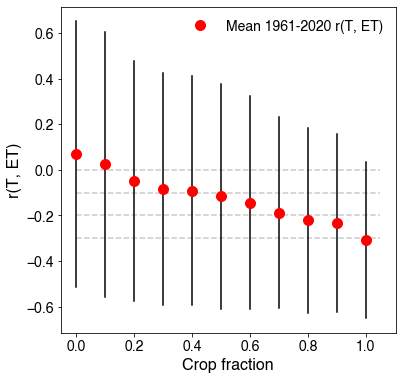

In [136]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_by_cf_bin.keys()):
    m = np.nanmean(r_t_et_by_cf_bin[k])
    sdev = np.nanstd(r_t_et_by_cf_bin[k])
    plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m, 'or', markersize=10, label='Mean 1961-2020 r(T, ET)')
    else:
        plt.plot(k, m, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 14}, frameon=False, loc='upper right')

# plt.savefig('mean-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

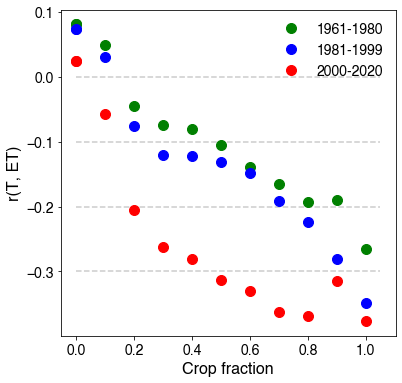

In [137]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_1_by_cf_bin.keys()):
    m1 = np.nanmean(r_t_et_1_by_cf_bin[k])
    sdev1 = np.nanstd(r_t_et_1_by_cf_bin[k])
    
    m2 = np.nanmean(r_t_et_2_by_cf_bin[k])
    sdev2 = np.nanstd(r_t_et_2_by_cf_bin[k])
    
    m3 = np.nanmean(r_t_et_3_by_cf_bin[k])
    sdev3 = np.nanstd(r_t_et_3_by_cf_bin[k])
#     plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m1, 'og', markersize=10, label='1961-1980')
        plt.plot(k, m2, 'ob', markersize=10, label='1981-1999')
        plt.plot(k, m3, 'or', markersize=10, label='2000-2020')
        
    plt.plot(k, m1, 'og', markersize=10)
    plt.plot(k, m2, 'ob', markersize=10)
    plt.plot(k, m3, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 14}, frameon=False, loc='upper right')

# plt.savefig('chg-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.figure(figsize=(6,6))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_1_by_cf_bin.keys()):
    m2 = np.nanmean(r_t_et_2_by_cf_bin[k])
    sdev2 = np.nanstd(r_t_et_2_by_cf_bin[k])
    
    m3 = np.nanmean(r_t_et_3_by_cf_bin[k])
    sdev3 = np.nanstd(r_t_et_3_by_cf_bin[k])
#     plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m3-m2, 'om', markersize=10, label='2000-2020 minus 1981-1999')
        
    plt.plot(k, m3-m2, 'om', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('r(T, ET)')
plt.legend(prop={'size': 14}, frameon=False, loc='upper right')

# plt.savefig('chg-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
%%time
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

if not os.path.isfile('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData):
    wave_days_t_max_trends = xr.apply_ufunc(new_linregress, wave_days_t_max_xr.time, wave_days_t_max_xr.t_max,
                           input_core_dims=[['time'], ['time']],
                           output_core_dims=[["p"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"p": 5},
                          )
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'wb') as f:
        pickle.dump(wave_days_t_max_trends, f)
else:
    with open('%s/heat-wave-days/full-year/trends/wave_days_t_max_trends.dat'%dirHeatData, 'rb') as f:
        wave_days_t_max_trends = pickle.load(f)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7,5))

x1 = 0
x2 = 90

ax1.scatter(crop_ha_regrid_1d, trends_wave_days_t_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax1.plot([x1, x2], [mdl_wave_days_t_max.params[0], mdl_wave_days_t_max.params[0]+x2*mdl_wave_days_t_max.params[1]], '--k', lw=2, \
         label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_t_max.params[1]*10))
ax1.set_title('Temperature', fontsize=18)
ax1.set_xlabel('Maize + soy cover (%)')
ax1.set_ylabel('Trend in 99th percentile\nheat wave days\nzonal anomaly (days/decade)')
ax1.set_xlim([0, 100])
ax1.set_ylim([-4.2, 3.5])
ax1.legend(prop={'size': 14}, frameon=False)

ax2.scatter(crop_ha_regrid_1d, trends_wave_days_tw_max_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
ax2.plot([x1, x2], [mdl_wave_days_tw_max.params[0], mdl_wave_days_tw_max.params[0]+x2*mdl_wave_days_tw_max.params[1]], '--k', lw=2, \
        label = 'slope = %.2f\ndays/decade/10%%'%(mdl_wave_days_tw_max.params[1]*10))
ax2.set_title('Wet bulb temperature', fontsize=18)
ax2.set_xlabel('Maize + soy cover (%)')
ax2.set_yticks(np.arange(-4, 3.1))
ax2.set_xlim([0, 100])
ax2.set_ylim([-4.2, 3.5])
ax2.legend(prop={'size': 14}, frameon=False)

# plt.savefig('figs/cropland-t-tw-zonal-mean-trends.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

# ax3.scatter(crop_ha_regrid_1d, trends_wave_days_t_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax3.plot([x1, x2], [mdl_wave_days_t_min.params[0], mdl_wave_days_t_min.params[0]+x2*mdl_wave_days_t_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_t_min.params[1]*10))
# ax3.set_title('T_min, q = %d'%q)
# ax3.set_xlabel('Crop cover (%)')
# ax3.set_ylabel('Cold wave days trend\nzonal anomaly\n(days/decade)')
# ax3.set_xlim([0, 100])
# # ax3.set_ylim([-4, 4])
# ax3.legend()

# ax4.scatter(crop_ha_regrid_1d, trends_wave_days_tw_min_zonal_anom_1d[:, q], s = 5, c = '#0094c9')
# ax4.plot([x1, x2], [mdl_wave_days_tw_min.params[0], mdl_wave_days_tw_min.params[0]+x2*mdl_wave_days_tw_min.params[1]], '--k', lw=2, \
#         label = 'slope = %.2f days/decade/10%%'%(mdl_wave_days_tw_min.params[1]*10))
# ax4.set_title('TW_min, q = %d'%q)
# ax4.set_xlabel('Crop cover (%)')
# ax4.set_xlim([0, 100])
# # ax4.set_ylim([-4, 4])
# ax4.legend()
